In [1]:
import os
from os import path
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy import io
import scipy as scipy
import collections
import scipy.sparse as sp_sparse
import tables
import time
import numba as nb
from numba import config
from numba_progress import ProgressBar
import ipdb
import matplotlib as plt
from tqdm.notebook import tqdm
from numba.typed import Dict
from scipy import sparse


from ABCA7lof2.setup import get_data, save_all, save_annotations, subset_mat
from ABCA7lof2.qc import filter_cells, filter_cells_by_major_annotation, filter_on_gaussian_logliklihood, get_total_counts, log_normalize_counts, get_fraction_mito, filter_cells_by_mito

from ABCA7lof2.annotation import get_major_annotations
from ABCA7lof2.singlecell import bulk_data, expressed_fraction

config.THREADING_LAYER = 'workqueue'

In [20]:
# define paths
meta_path = './raw_data/cellranger_counts_out/aggr_out/metadata.npy'
features_name_path = './raw_data/cellranger_counts_out/aggr_out/features_name.npy'
matrix_path = './raw_data/cellranger_counts_out/aggr_out/counts.npy'
features_id_path = './raw_data/cellranger_counts_out/aggr_out/features_id.npy'
barcodes_path = './raw_data/cellranger_counts_out/aggr_out/barcodes.npy'
70
# load data
counts = np.lib.format.open_memmap(matrix_path, mode='r')
features_name = np.lib.format.open_memmap(features_name_path, mode='r')
features_id = np.lib.format.open_memmap(features_id_path, mode='r')
barcodes = np.lib.format.open_memmap(barcodes_path, mode='r')
meta = np.load(meta_path, allow_pickle=True)

# get column names
meta_col_names = np.array(pd.read_csv('./raw_data/metadata/single_cell_individual_metadata.csv', index_col=0).columns)

# run checks
temp = features_name.reshape((len(np.unique(meta[:,1])), counts.shape[1]))
if np.unique([np.array_equal(temp[0], x) for x in temp])[0]:
    print('Feature names were aggregated correctly across samples.')
    
temp = features_id.reshape((len(np.unique(meta[:,1])), counts.shape[1]))
if np.unique([np.array_equal(temp[0], x) for x in temp])[0]:
    print('Feature IDs were aggregated correctly across samples.')
    
# concatenate features and metadata
features = np.concatenate((features_name[:counts.shape[1]].reshape(-1,1), features_id[:counts.shape[1]].reshape(-1,1)), axis=1)
meta = np.concatenate((barcodes.reshape(-1,1), meta), axis=1)


Feature names were aggregated correctly across samples.
Feature IDs were aggregated correctly across samples.


In [3]:
# run initial cell filtering
mito_index, total_counts, mito_fractions, filtered_meta, filtered_counts  = filter_cells(features[:,0], counts, meta, 1, 500, 10000, plt.backends.backend_pdf.PdfPages('./pdf_figures/single_cell_qc.pdf'), 'MT-', './processed_data/single_cell')

getting mito fractions
searching for best params
gaussian gridsearch
Number of components               5
Type of covariance              full
BIC score               64236.823909
Name: 46, dtype: object
All cells
150456
Mito keep
0.8869104588716967


  0%|          | 0/150456 [00:00<?, ?it/s]

All keep:
0.8688719625671293
Mito fraction mean discard:
0.19132662876325177
Mito fraction mean keep:
0.014265013685430653


  0%|          | 0/130727 [00:00<?, ?it/s]

In [22]:
# run PCA
annotations, marker_out, projected_matrix, predict, scores, marker_genes, marker_indices = get_major_annotations('./processed_data/single_cell/brain_marker_genes.csv', features[:,0], filtered_counts, total_counts, 1, 50, 10, './processed_data/single_cell', None)

using prior markers for reduction & annotation...
getting marker indices...
getting normalized marker matrix...


  0%|          | 0/130727 [00:00<?, ?it/s]

running pca...
estimating gaussian mixture model...
gaussian gridsearch
Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5; 1/11] START covariance_type=full, n_components=0.......................
[CV 1/5; 1/11] END covariance_type=full, n_components=0;, score=nan total time=   0.0s
[CV 2/5; 1/11] START covariance_type=full, n_components=0.......................
[CV 2/5; 1/11] END covariance_type=full, n_components=0;, score=nan total time=   0.0s
[CV 3/5; 1/11] START covariance_type=full, n_components=0.......................
[CV 3/5; 1/11] END covariance_type=full, n_components=0;, score=nan total time=   0.0s
[CV 4/5; 1/11] START covariance_type=full, n_components=0.......................
[CV 4/5; 1/11] END covariance_type=full, n_components=0;, score=nan total time=   0.0s
[CV 5/5; 1/11] START covariance_type=full, n_components=0.......................
[CV 5/5; 1/11] END covariance_type=full, n_components=0;, score=nan total time=   0.0s
[CV 1/5; 2/11] START covari

/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 55.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 730, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py", line 181, in fit
    self.fit_predict(X, y)
  File "/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/home/gridsan/djuna

Number of components                10
Type of covariance                full
BIC score               2940016.918488
Name: 10, dtype: object
computing celltype summary scores...
annotating cell types...


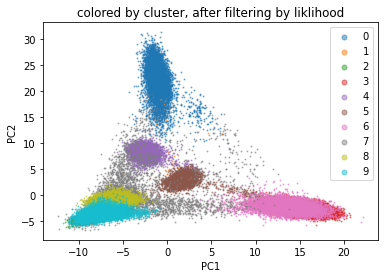

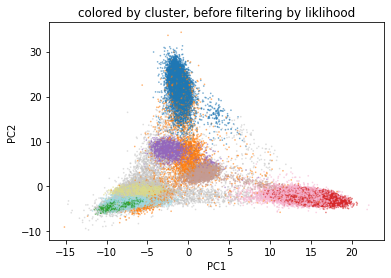

Text(0, 0.5, 'PC2')

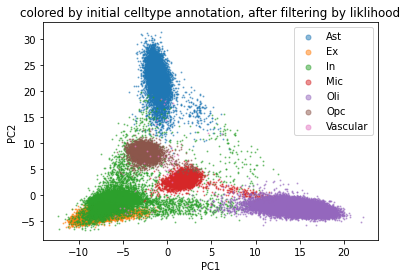

In [176]:
# plot cluster annotations and temporary celltype annos
index = scores>-100
for i in np.unique(predict):
    plt.pyplot.scatter(projected_matrix[index&(predict==i),0], projected_matrix[index&(predict==i),1], s=1, alpha=.5, label=i)
plt.pyplot.legend( markerscale=5)
plt.pyplot.xlabel('PC1')
plt.pyplot.ylabel('PC2')
plt.pyplot.title('colored by cluster, after filtering by liklihood')
plt.pyplot.show()

plt.pyplot.scatter(projected_matrix[:,0], projected_matrix[:,1], s=.5, alpha=0.5, c=predict,cmap='tab20')
plt.pyplot.xlabel('PC1')
plt.pyplot.ylabel('PC2')
plt.pyplot.title('colored by cluster, before filtering by liklihood')

plt.pyplot.show()

for i in np.unique(annotations):
    plt.pyplot.scatter(projected_matrix[index&(annotations==i),0], projected_matrix[index&(annotations==i),1], s=1, alpha=.5, label=i)
plt.pyplot.legend( markerscale=5)
plt.pyplot.title('colored by initial celltype annotation, after filtering by liklihood')

plt.pyplot.xlabel('PC1')
plt.pyplot.ylabel('PC2')

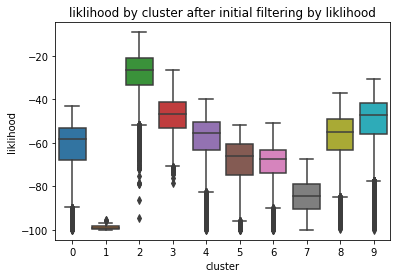

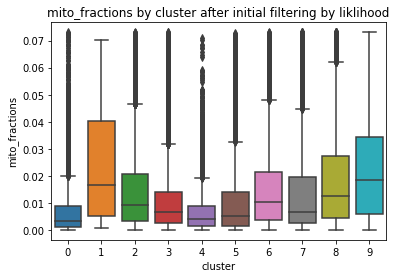

In [178]:
import seaborn as sns
sns.boxplot(x=predict[index], y=scores[index])
plt.pyplot.xlabel('cluster')
plt.pyplot.ylabel('liklihood')
plt.pyplot.title('liklihood by cluster after initial filtering by liklihood')
plt.pyplot.show()
sns.boxplot(x=predict[index], y=mito_fractions[index])
plt.pyplot.xlabel('cluster')
plt.pyplot.ylabel('mito_fractions')
plt.pyplot.title('mito_fractions by cluster after initial filtering by liklihood')
plt.pyplot.show()

In [179]:
# remove clusters 1 and 7 based on liklihood
index = index&(predict!=1)&(predict!=7)

In [191]:
filtered_counts.shape[0]-np.sum(index)

12059

Text(0, 0.5, 'PC2')

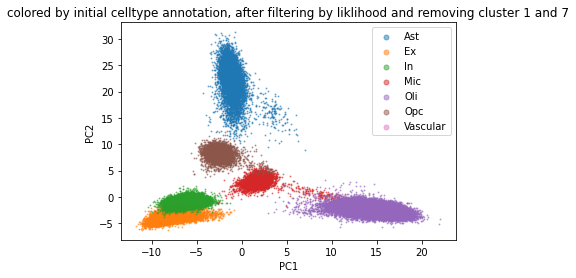

In [180]:
for i in np.unique(annotations):
    plt.pyplot.scatter(projected_matrix[index&(annotations==i),0], projected_matrix[index&(annotations==i),1], s=1, alpha=.5, label=i)
plt.pyplot.legend( markerscale=5)

plt.pyplot.title('colored by initial celltype annotation, after filtering by liklihood and removing cluster 1 and 7')

plt.pyplot.xlabel('PC1')
plt.pyplot.ylabel('PC2')

In [181]:
from scipy import stats
print('ttest mito fractions:', stats.ttest_ind(mito_fractions[index], mito_fractions[np.invert(index)]))
print('mean keep:', np.mean(mito_fractions[index]))
print('mean discard:', np.mean(mito_fractions[np.invert(index)]))

print('ttest total_counts:', stats.ttest_ind(total_counts[index], total_counts[np.invert(index)]))
print('mean keep:', np.mean(total_counts[index]))
print('mean discard:', np.mean(total_counts[np.invert(index)]))

ttest mito fractions: Ttest_indResult(statistic=-16.004223337246913, pvalue=1.3546384489033495e-57)
mean keep: 0.014046120944248952
mean discard: 0.01641905330816473
ttest total_counts: Ttest_indResult(statistic=68.27439445798937, pvalue=0.0)
mean keep: 11289.784524892979
mean discard: 3807.112530060536


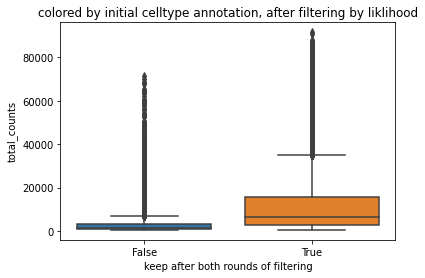

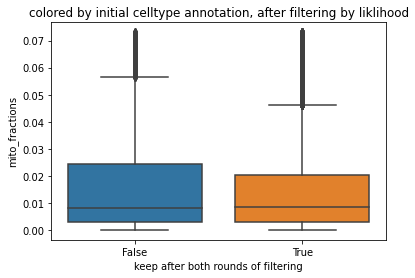

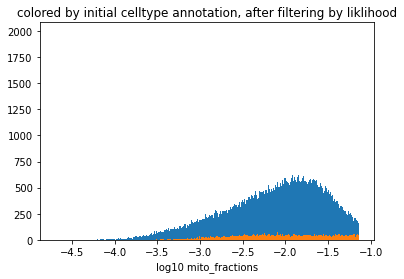

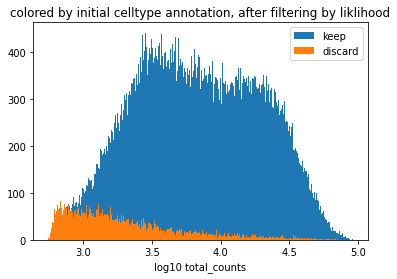

In [183]:
# plot distributions
import seaborn as sns
sns.boxplot(x=index, y=total_counts)
plt.pyplot.title('colored by initial celltype annotation, after filtering by liklihood')
plt.pyplot.xlabel('keep after both rounds of filtering')
plt.pyplot.ylabel('total_counts')
plt.pyplot.show()

sns.boxplot(x=index, y=mito_fractions)
plt.pyplot.title('colored by initial celltype annotation, after filtering by liklihood')
plt.pyplot.xlabel('keep after both rounds of filtering')
plt.pyplot.ylabel('mito_fractions')
plt.pyplot.show()

plt.pyplot.hist(np.log10(mito_fractions[index]+2e-5), 500)
plt.pyplot.hist(np.log10(mito_fractions[np.invert(index)]+2e-5), 500)
plt.pyplot.title('colored by initial celltype annotation, after filtering by liklihood')
plt.pyplot.xlabel('log10 mito_fractions')
None
plt.pyplot.show()


plt.pyplot.hist(np.log10(total_counts[index]+2e-5), 500, label='keep')
plt.pyplot.hist(np.log10(total_counts[np.invert(index)]+2e-5), 500, label='discard')
plt.pyplot.legend()
plt.pyplot.title('colored by initial celltype annotation, after filtering by liklihood')
plt.pyplot.xlabel('log10 total_counts')
None
plt.pyplot.show()


In [189]:
counts.shape[0]-filtered_counts.shape[0]

19729

In [184]:
# plot n cells before filtering
np.unique(annotations, return_counts=True)

(array(['Ast', 'Ex', 'In', 'Mic', 'Oli', 'Opc', 'Vascular'], dtype='<U8'),
 array([ 8671, 46823, 23471,  6579, 35537,  6311,  3335]))

In [185]:
# plot n cells after filtering
np.unique(annotations[index], return_counts=True)

(array(['Ast', 'Ex', 'In', 'Mic', 'Oli', 'Opc'], dtype='<U8'),
 array([ 8380, 46806, 15982,  6136, 35236,  6128]))

In [172]:
# compile metadata
filtered_meta_final = np.concatenate((filtered_meta,index.reshape(-1,1), predict.reshape(-1,1), scores.reshape(-1,1), annotations.reshape(-1,1), total_counts.reshape(-1,1), mito_fractions.reshape(-1,1)), axis = 1)
meta_names = np.concatenate((np.concatenate((np.array(['barcodes','index']), meta_col_names), axis=0), np.array(('keep_cells_all_per_celltype', 'keep_cells_gaussian', 'predictions', 'gaussian_liklihood', 'annotations', 'total_counts', 'mito_fractions'))), axis = 0)
# save data
np.save('./processed_data/single_cell/filtered_meta.npy', filtered_meta_final)
np.save('./processed_data/single_cell/meta_names.npy', meta_names)
np.save('./processed_data/single_cell/features.npy', features)
np.save('./processed_data/single_cell/projected_matrix.npy', projected_matrix)
np.save('./processed_data/single_cell/marker_indices.npy', marker_indices)

# save genes that are being considered based on criteria
logcounts = np.memmap('./processed_data/single_cell/filtered_logcounts.npy', mode='w+', shape=filtered_counts.shape, dtype='float')
log_normalize_counts(filtered_counts, total_counts, logcounts)

100%|██████████| 130727/130727 [02:40<00:00, 814.51it/s]


In [234]:
# save protein coding index
g = pd.read_csv('./raw_data/ensembl.GRCh38p12.genes.complete.annot.csv')
genes = set(g['Gene.stable.ID'][(g['Gene.type']=='protein_coding')&(g['Chromosome.scaffold.name']!='MT')])
index = [x in genes for x in features[:,1]]
features_temp = features[index]
np.save('./processed_data/single_cell/features_proteincoding_index.npy', index)
